# **EA619 - Laboratório de Análise Linear**
## Experimento 3 - Harmônicas
### Bryan Wolff - RA: 214095
### João Luís Carvalho de Abreu - RA: 175997



## **Importando Bibliotecas**

In [ ]:
!pip install pysoundfile

In [ ]:
#Geral
import math
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal

#Audio
from IPython.display import Audio
from scipy.io import wavfile
import cffi
import librosa
import IPython.display as ipd

#Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#mostrar todas saídas
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## **Rotinas**

**Rotinas: Espectro e Plot**

In [ ]:
def espectro(func, fs):
    sinal = np.fft.fft(func) #transf. de Fourier
    sinal = sinal[0:len(sinal)//2] #frequências positivas
    sinal = np.abs(sinal) #módulo do sinal
    w = np.linspace(0,fs/2,sinal.size) #frequencias avaliadas
    return w,sinal

#Rotina para plotar gráficos, passe outros vetores x,y em otherplots para plotar mais gráficos em uma figura
def plot(x, y, title = "", x_name = "", y_name = "", color_line = '#0ccf08', *otherplots):
    plt.figure() 
    j = 0
    if type(color_line) == list:
        plt.plot(x,y, color = color_line[j])
        if len(color_line) > 1: j = j + 1
    else:
        plt.plot(x,y, color = color_line)
    if otherplots != 0:
        for i in range(0, len(otherplots), 2):
            if type(color_line) == list:
                if (len(color_line) > (len(otherplots))) or (len(color_line) == (len(otherplots))):
                    plt.plot(otherplots[i],otherplots[i+1], color=color_line[j])
                    j = j + 1
                else:
                    plt.plot(otherplots[i],otherplots[i+1], color=color_line[0])
            else:
                 plt.plot(otherplots[i],otherplots[i+1])
    plt.title(title)
    plt.xlabel(x_name, fontsize=10)
    plt.ylabel(y_name, fontsize=10)
    plt.grid(True)
    plt.show()

## **Arquivo de Áudio - Não Linearidade**


A presença de não linearidades neste sinal é uma das causas do surgimento de componentes harmônicos em um sinal senoidal. Para demonstrar este caso, vamos inicialmente observar o espectro da transformada de Fourier de um sinal senoidal puro gravado pelo microfone do computador.

Text(0.5, 1.0, 'Espectro do tom de 440 Hz puro')

(0.0, 10000.0)

<Figure size 432x288 with 0 Axes>

(0.0, 0.025)

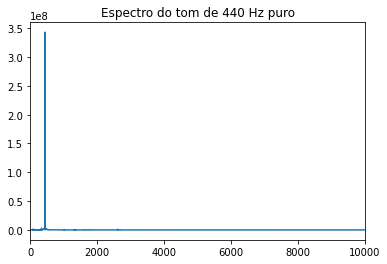

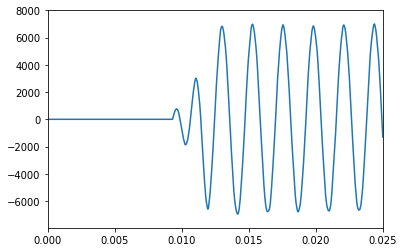

In [ ]:
#Leitura de arquivo de áudio do drive
Tom_puro = drive.CreateFile({'id':'1qCTpaDvLTUpihCwqPJRXQxZn1oGa0CCJ'})
Tom_puro.GetContentFile('tom-puro.wav')

#Análise da resposta do sistema de microfone do computador

fs, tom_puro = wavfile.read('tom-puro.wav')

tom_puro = tom_puro[:100000] #Limitando o número de amostras
tom_puro = tom_puro[:,0] #Selecionando apenas um canal de áudio
N = len(tom_puro)

fft_puro = np.fft.fft(tom_puro)
f=np.arange(N)*fs/N
plt.plot(f[0:int(N/2)],np.abs(fft_puro)[0:int(N/2)])
plt.title('Espectro do tom de 440 Hz puro')
plt.xlim(0,10000)

plt.figure()
plt.xlim(0,0.025)
t = np.arange(N)/fs
plt.plot(t,tom_puro)

ipd.Audio(tom_puro,rate=fs)

Se comparar este espectro com um outro espectro de um sinal com mesmo tom, porém gravado em um volume no qual ocorre uma saturação do sinal, observa-se o surgimento de frequências que não são do tom original.

Text(0.5, 1.0, 'Espectro do tom de 440 Hz distorcido')

(0.0, 10000.0)

<Figure size 432x288 with 0 Axes>

(0.0, 0.025)

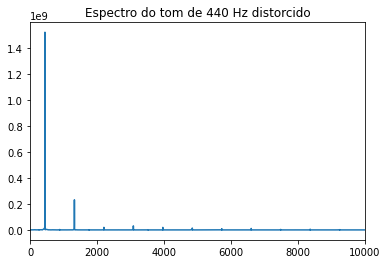

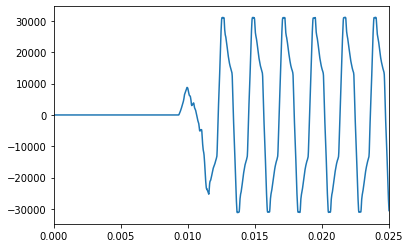

In [ ]:
#Leitura de arquivo de áudio do drive
distorcido = drive.CreateFile({'id':'1y3YC7YwHTse0_GPCsqt1dVXMyjC86aNH'})
distorcido.GetContentFile('distorcido.wav')

#Análise da resposta do sistema de microfone do computador com saturação
fs, distorcido = wavfile.read('distorcido.wav')

distorcido = distorcido[:100000] #Limitando o número de amostras
distorcido = distorcido[:,0] #Selecionando apenas um canal de áudio
N = len(distorcido)

fft_distorcido = np.fft.fft(distorcido)
f=np.arange(N)*fs/N
plt.plot(f[0:int(N/2)],np.abs(fft_distorcido)[0:int(N/2)])
plt.title('Espectro do tom de 440 Hz distorcido')
plt.xlim(0,10000)

plt.figure()
plt.xlim(0,0.025)
t = np.arange(N)/fs
plt.plot(t,distorcido)

ipd.Audio(distorcido, rate=fs)

## **Retificador de Meia Onda**

Outra fonte comum de não-linearidades são chaveamentos e transições abruptas no sinal, que ocorrem comumente em retificadores (circuitos elétricos de tensão elaborados para a conversão de corrente alternada em corrente de passagem) e equipamentos de eletrônica de potência. 

Para analisar seu efeito, vamos considerar inicialmente o sinal senoidal de tensão da rede elétrica e em seguida vamos observar o espectro de fourier de uma onda quadrada com a mesma frequencia do sinal senoidal.

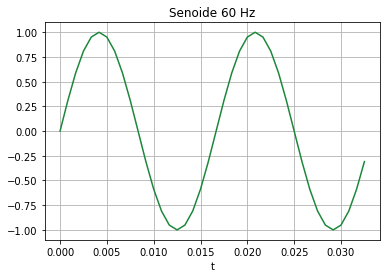

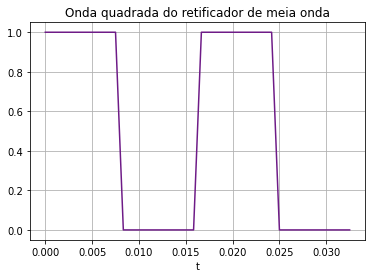

In [ ]:
fs=1200
length=1
t=np.arange(0,length,1/fs)
fm=60
senoide=np.sin(2*np.pi*t*fm)
square_block=np.append(np.ones(int(fs/(2*fm))),np.zeros(int(fs/(2*fm))))
square=np.tile(square_block,int(length*fm))
ret = square*senoide

plot(t[0:2*int(fs/fm)],senoide[0:2*int(fs/fm)],'Senoide 60 Hz', 't', '', '#1b873a')
plot(t[0:2*int(fs/fm)],square[0:2*int(fs/fm)],'Onda quadrada do retificador de meia onda', 't', '', '#6e1b87')

#### *Qual deve ser o espectro de um retificador de meia onda? (O produto de uma senóide com a onda quadrada)*

Para definir o espectro do retificador de meia onda, vamos abordar uma análise qualitativa do problema proposto. 

Dado um sinal senoidal $f(t) = sin(\omega_0\cdot t)$, é possível, a partir da literatura, obter a seguinte transformada de Fourier:

$F(j\omega) = \frac{\pi}{j}[\delta (\omega - \omega_0) - \delta (\omega + \omega_0)]$

De maneira geral, o espectro dessa função corresponde a dois impulsos, um na frequência fundamental na faixa positiva do espectro e o outro na mesma frequência, porém na faixa negativa do espectro.

Dado a onda quadrada periódica em $T$, definida por:

$x(t) = \begin{cases}
0 & \text{ se } |t|<T_1 \\ 
1 & \text{ se } T_1<|t|\leq \frac{T}{2}
\end{cases}$

Esse sinal, possuí a seguinte transformada de Fourier:

$X(j\omega) = \sum_{k=-\infty}^{\infty} \frac{2\cdot sin(k\cdot \omega_0\cdot T_1)}{k}\cdot \delta (\omega - k\cdot \omega_0)$

Em termos gerais, o espectro da função acima corresponde a um somatório de impulsos multiplos ímpares da frequência fudamental. 

Dessa forma, o espectro do retificador de meia onda é definido pela multiplicação no tempo da senoide pela onda quadrada ou pela convolução na frequência das duas transformadas obtidas:

$e(t) = x(t)\cdot y(t) \rightarrow E(j\omega) = \frac{1}{2\pi}F(j\omega)*X(j\omega)$

Assim, é esperado que a convolução dos dois espectros resulte em um somatório de impulsos multiplos da frequência fundamental.

#### Trace a onda retificada e o seu espectro.

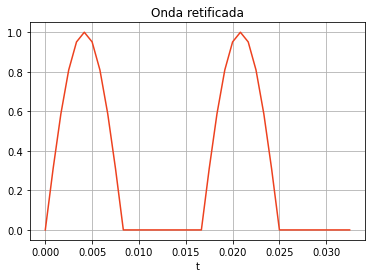

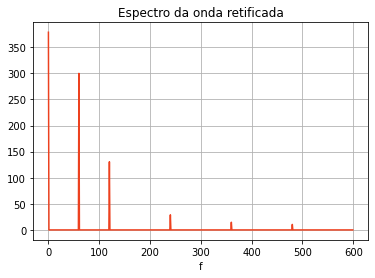

In [ ]:
plot(t[0:2*int(fs/fm)],ret[0:2*int(fs/fm)], 'Onda retificada', 't', '', '#ed411f')

N=len(t)
fft_ret = np.fft.fft(ret)
f=np.arange(N)*fs/N
plot(f[0:int(N/2)],np.abs(fft_ret)[0:int(N/2)],'Espectro da onda retificada', 'f', '' ,'#ed411f')

#### *Identifique as principais frequências que aparecem no espectro e explique a sua origem.*

As principais frequências que aparecem no espectro, que correspondem às distorções harmônicas do sinal, são de **0 Hz, 60 Hz, 120 Hz, 240 Hz, 360 Hz e 480 Hz**. Essas distorções se apresentam de forma a conter apenas frequências múltiplas inteiras da frequência fundamental, onde geralmente é causada por dispositivos que apresentam uma relação não linear entre tensão e corrente.

Existem diversos dispositivos com circuitos não lineares que causam essas distorções, entre eles estão os diodos, os transformadores e motores, cujos núcleos ferromagnéticos são sujeitos à saturação, as cargas eletrônicas que produzem descontinuidades na corrente devido ao chaveamento dos conversores, e outros exemplos citados na apostila do Prof. Antenor Pomilio.


## **Retificador de Onda Completa**


Se observarmos um retificador de onda completa, observamos o seguinte espectro:

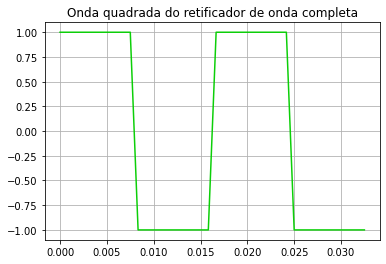

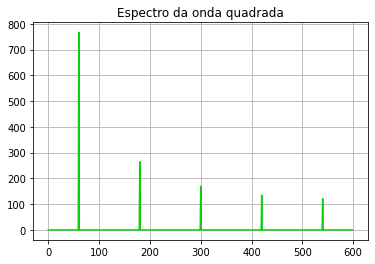

In [ ]:
square2_block=np.append(np.ones(int(fs/(2*fm))),-np.ones(int(fs/(2*fm))))
square2=np.tile(square2_block,int(length*fm))
plot(t[0:2*int(fs/fm)],square2[0:2*int(fs/fm)], 'Onda quadrada do retificador de onda completa')

N=len(t)
fft_square2=np.fft.fft(square2)
f=np.arange(N)*fs/N
plot(f[0:int(N/2)],np.abs(fft_square2)[0:int(N/2)],'Espectro da onda quadrada')


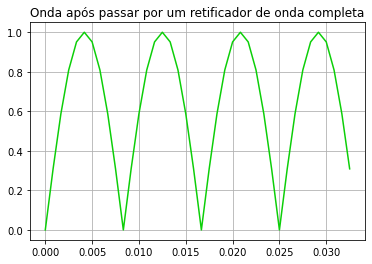

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

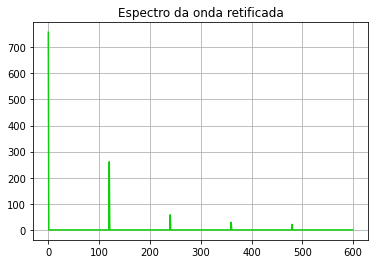

In [ ]:
ret_completo=np.multiply(senoide,square2)
plot(t[0:2*int(fs/fm)],ret_completo[0:2*int(fs/fm)], 'Onda após passar por um retificador de onda completa')

plt.figure()
fft_ret_completo=np.fft.fft(ret_completo)
f=np.arange(N)*fs/N
plot(f[0:int(N/2)],np.abs(fft_ret_completo)[0:int(N/2)], 'Espectro da onda retificada')

#### *Qual a diferença entre o espectro do retificador de meia onda e o de onda completa? Qual a causa dessa diferença?*

O espectro do retificador de meia onda possuí uma frequência fundamental de $60Hz$ com a presença de harmônicas pares multiplas dessa frequência. 
No caso do retificador de onda completa, a frequência fundamental passa a ser $120Hz$, porém com a presença de harmônicas tanto pares quanto ímpares. Vale ressaltar que o sinal retificado de meia onda apresenta comportamento assimétrico o que implica no surgimento apenas das harmônicas pares. No caso do retificador completo, por sua vez, a simetria é de onda completa o que implica no surgimento das harmônicas pares e ímpares.

## **Tiristor**

Um outro dispositivo de eletrônica de potência é o tiristor, que é capaz de controlar o momento de início da condução de um retificador. O espectro da onda senoidal após passar por um desses dispositivos é apresentado abaixo:

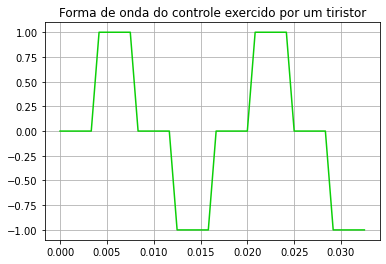

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

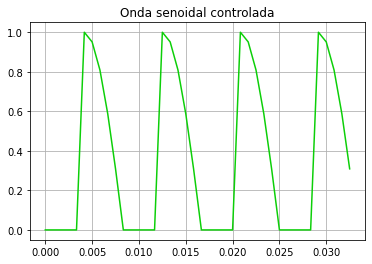

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

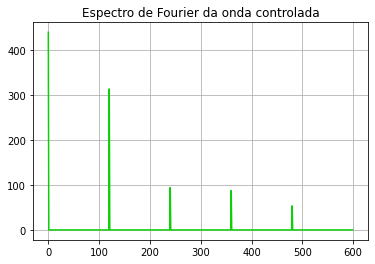

In [ ]:
square_block_tir=np.append(np.zeros(int(fs/(4*fm))),np.ones(int(fs/(4*fm))))
square_block_tir=np.append(square_block_tir,-square_block_tir)
square_tir=np.tile(square_block_tir,int(length*fm))
plot(t[0:2*int(fs/fm)],square_tir[0:2*int(fs/fm)], 'Forma de onda do controle exercido por um tiristor')

ret_tir=np.multiply(senoide,square_tir)
plt.figure()
plot(t[0:2*int(fs/fm)],ret_tir[0:2*int(fs/fm)], 'Onda senoidal controlada')

plt.figure()
fft_ret_tir=np.fft.fft(ret_tir)
f=np.arange(N)*fs/N
plot(f[0:int(N/2)],np.abs(fft_ret_tir)[0:int(N/2)],'Espectro de Fourier da onda controlada')

Podemos observar que apesar da forma da onda do tiristor ser muito diferente da onda que passou por um retificador de onda completa, seu espectro de Fourier é muito semelhante.

#### *Porque a diferença do sinal no tempo não se reflete no espectro apresentado?*

A forma de onda exercida por um tiristor possuí um mesmo período de oscilação em comparação com o sinal do retificador de onda completa, ou seja, a frequência fundamental neste caso é dada por $120Hz$. Nesta perspectiva, mesmo que haja uma mudança do sinal no tempo, a frequência fundamental deste sinal é a mesma, não implicando em mudanças significativas nas harmônicas do espectro apresentado.

#### *De qual forma podemos observar diferença entre esses dois sinais no domínio de Fourier?*

É possível observar a diferença entre esses dois sinais a partir da magnitude do módulo da transformada de Fourier. No caso do retificador de onda completa, a magnitude do espectro será maior apenas na harmônica referente a $f = 0Hz$. Porém, para a frequência fundamental e as demais harmônicas do espectro, a magnitude no domínio da transformada de Fourier do tiristor é consideravelmente maior. Portanto, ainda que os sinais apresentem harmônicas nas mesmas frequências, é notável esta diferença com relação à magnitude.

## **Filtro Ativo - Passa Baixa**

Nesta etapa, criamos um filtro para remover as harmônicas geradas e para limpar o sinal recortado pelo retificador de meia onda de forma a preservar somente a frequência fundamental. Ao utilizar um filtro passa baixa, porém, apenas as frequências superiores a fundamental serão eliminadas. Assim, é necessário somar uma tensão de compensação de forma a eliminar a harmônica presente em $f = 0 Hz$.

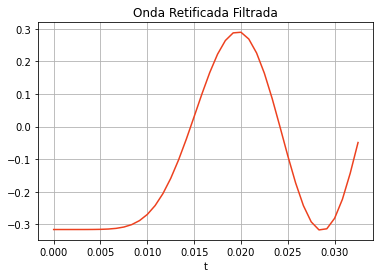

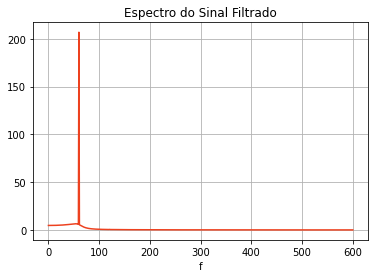

In [ ]:
sos = signal.butter(8,fm, btype = 'lowpass', fs=fs, output='sos')
ret_filtrado = signal.sosfilt(sos, ret)

#Tensão de compensação
Vcomp = np.average(ret)
ret_filtrado = [i - Vcomp for i in ret_filtrado]

plot(t[0:2*int(fs/fm)],ret_filtrado[0:2*int(fs/fm)], 'Onda Retificada Filtrada', 't', '', '#ed411f')

w, Y = espectro(ret_filtrado, fs)
plot(w[0:int(N/2)],Y[0:int(N/2)], 'Espectro do Sinal Filtrado', 'f', '', '#ed411f')

## **Outra alternativa: Filtro Ativo - Passa Faixa**

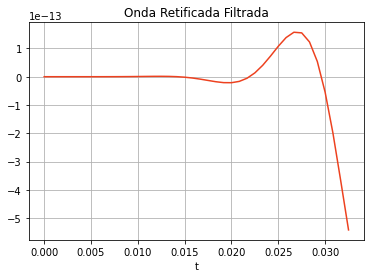

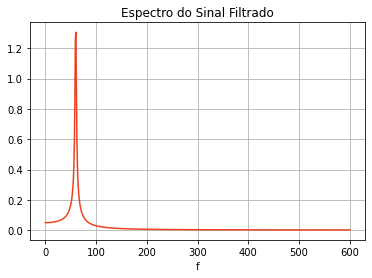

In [ ]:
sos = signal.butter(8, (59, 60), btype = 'bandpass', fs = fs, output = 'sos')
ret_filtrado = signal.sosfilt(sos, ret)

plot(t[0:2*int(fs/fm)],ret_filtrado[0:2*int(fs/fm)], 'Onda Retificada Filtrada', 't', '', '#ed411f')

w, Y = espectro(ret_filtrado, fs)
plot(w[0:int(N/2)],Y[0:int(N/2)], 'Espectro do Sinal Filtrado', 'f', '', '#ed411f')